## Cell Classification project

#### Import packages

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split

#### Path

In [2]:
Main_Train_Path = Path(r"cell_images\train")
Main_Test_Path = Path(r"cell_images\test")
os.listdir(Main_Train_Path)

['parasitized', 'uninfected']

In [3]:
Train_PNG_Path = list(Main_Train_Path.glob(r"*/*.png"))
Test_PNG_Path = list(Main_Test_Path.glob(r"*/*.png"))
Train_PNG_Path = [str(path) for path in Train_PNG_Path]
Test_PNG_Path = [str(path) for path in Test_PNG_Path]
print(Train_PNG_Path[0:5])

['cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png', 'cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_163.png', 'cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_164.png', 'cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_165.png', 'cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_166.png']


#### Label

In [4]:
Train_PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Train_PNG_Path))
print("Train Parasitized: ",Train_PNG_Labels.count("parasitized"))
print("Train Uninfected: ",Train_PNG_Labels.count("uninfected"))

Train Parasitized:  12479
Train Uninfected:  12479


In [5]:
Test_PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Test_PNG_Path))
print("Test Parasitized: ",Test_PNG_Labels.count("parasitized"))
print("Test Uninfected: ",Test_PNG_Labels.count("uninfected"))

Test Parasitized:  1300
Test Uninfected:  1300


In [6]:
# Map labels to integers: 'parasitized' -> 0, 'uninfected' -> 1
label_map = {'parasitized': 0, 'uninfected': 1}
Train_PNG_Labels = [label_map[label] for label in Train_PNG_Labels]
Test_PNG_Labels = [label_map[label] for label in Test_PNG_Labels]

In [7]:
# Function to load and preprocess images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Resize to a fixed size
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

In [8]:
# Function to create a TensorFlow dataset
def create_dataset(paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(paths))
    dataset = dataset.batch(batch_size=32)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [9]:
# Split the data into training and validation sets
print(len(Train_PNG_Labels))
train_paths, val_paths, train_labels, val_labels = train_test_split(Train_PNG_Path, Train_PNG_Labels, test_size=0.2, random_state=42)
print("After spliting Training data to Training & Validation:")
print("Train data: ", len(train_paths), " Validation data: " , len(val_paths))
train_dataset = create_dataset(train_paths, train_labels)
val_dataset = create_dataset(val_paths, val_labels)

24958
After spliting Training data to Training & Validation:
Train data:  19966  Validation data:  4992


In [10]:
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


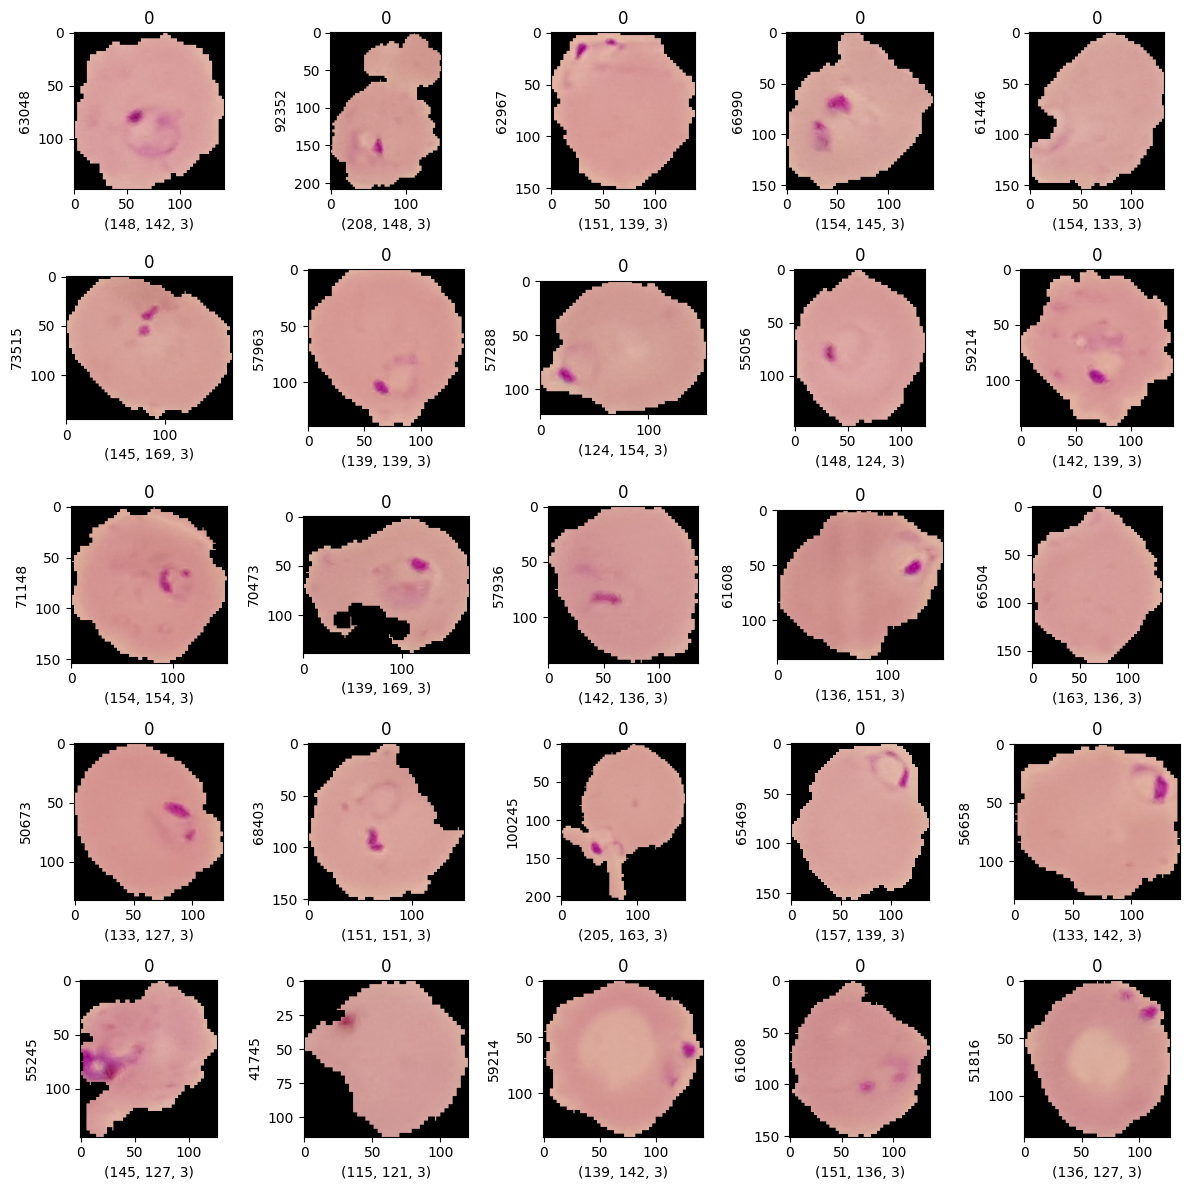

In [11]:
figure,axis = plt.subplots(nrows=5,ncols=5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    IMG = imread(Train_PNG_Path[i])
    ax.set_xlabel(IMG.shape)
    ax.set_ylabel(IMG.size)
    ax.set_title(Train_PNG_Labels[i])
    ax.imshow(IMG,cmap="Greys_r")
plt.tight_layout()
plt.show()

In [12]:
#using Keras Sequential model and Dense Layer with a ReLU activation to construct the three layer network described above.
tf.random.set_seed(1234) # for consistent results
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Single output for binary classification
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10


624/624 [==============================] - 273s 426ms/step - loss: 0.3149 - accuracy: 0.8641 - val_loss: 0.1953 - val_accuracy: 0.9379
Epoch 2/10
624/624 [==============================] - 243s 377ms/step - loss: 0.1605 - accuracy: 0.9470 - val_loss: 0.1476 - val_accuracy: 0.9539
Epoch 3/10
624/624 [==============================] - 252s 391ms/step - loss: 0.1308 - accuracy: 0.9565 - val_loss: 0.1376 - val_accuracy: 0.9551
Epoch 4/10
624/624 [==============================] - 255s 395ms/step - loss: 0.1154 - accuracy: 0.9608 - val_loss: 0.1724 - val_accuracy: 0.9437
Epoch 5/10
624/624 [==============================] - 253s 392ms/step - loss: 0.1060 - accuracy: 0.9632 - val_loss: 0.1326 - val_accuracy: 0.9591
Epoch 6/10
624/624 [==============================] - 257s 398ms/step - loss: 0.0857 - accuracy: 0.9694 - val_loss: 0.1450 - val_accuracy: 0.9583
Epoch 7/10
624/624 [==============================] - 260s 401ms/step - loss: 0.0703 - accuracy: 0.9745 - val_loss: 0.1626 - val_accura

In [14]:
test_dataset = create_dataset(Test_PNG_Path,Test_PNG_Labels)
predictions = model.predict(test_dataset)
print(predictions[0])

82/82 [==============================] - 12s 94ms/step
[0.9997219]


In [22]:
result = model.evaluate(test_dataset)
print("Test loss, Test Accuracy: ", result)

82/82 [==============================] - 8s 91ms/step - loss: 0.2628 - accuracy: 0.9423
Test loss, Test Accuracy:  [0.2627905011177063, 0.942307710647583]
